In [1]:
import subprocess
import shlex
import re
import json

import numpy as np
import multiprocessing as mp

from matplotlib import pyplot as plt
from scipy import stats
from tqdm import tqdm
from IPython.display import display, Markdown
from tempfile import TemporaryDirectory

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

def show():
    plt.savefig(f"{show.fig_counter}.pdf", dpi='figure', transparent=True, bbox_inches='tight')
    show.fig_counter += 1
    show.plt_show()

show.fig_counter = 0
show.plt_show = plt.show

plt.show = show

In [3]:
import scipy.special as sp

def s_island(A_eff, deme, nu):
    theta_A_eff = (deme * A_eff - 1.0) * nu / (1.0 - nu)
    
    return theta_A_eff * (sp.digamma(theta_A_eff + deme * A_eff) - sp.digamma(theta_A_eff))

def s_island_limit(A_eff, deme, nu):
    return ((A_eff * deme - 1.0) * nu * np.log(1.0 / nu)) / (1.0 - nu)

In [4]:
BIODIVERSITY_PATTERN = re.compile(r"The simulation resulted in a biodiversity of (\d+) unique species\.")
TIMING_PATTERN = re.compile(r"The simulation finished at time (\d+\.\d+) after (\d+) steps\.")

In [5]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

In [6]:
def simulate_non_spatial_monolithic(algorithm, speciation=0.1, seed=42, size=(10, 10, 10), spatial=False):
    config = "".join(f"""
    (
        speciation: {speciation},
        sample: 1.0,
        seed: {seed},

        algorithm: {algorithm},

        log: None,

        scenario: NonSpatial(
            area: ({size[0]}, {size[1]}),
            deme: {size[2]},
            spatial: {str(spatial).lower()},
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                reporters: [Biodiversity()]
            )
        ],
    )
    """.split()).replace(",)", ")").replace(",]", "]")

    # Run the simulation
    result = subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + "rustcoalescence-algorithms-independent,necsim-partitioning-mpi "
        + f"--quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True)

    match = BIODIVERSITY_PATTERN.search(result.stdout)
    if match is None:
        print(result.stdout)
        print(result.stderr)
    biodiversity = int(match.group(1))

    match = TIMING_PATTERN.search(result.stdout)
    if match is None:
        print(result.stdout)
        print(result.stderr)
    time = float(match.group(1))
    steps = int(match.group(2))
        
    return biodiversity, time, steps

In [7]:
def batch_simulation_many_seeds(simulate, seeds, args=tuple(), kwargs=dict(), silent=False, processes=mp.cpu_count()):
    results = []

    with tqdm(total=len(seeds), disable=silent) as progress:
        def update_progress(result):
            results.append(result)

            progress.update()
        
        def update_error(err):
            print(err)

        with mp.Pool(processes) as pool:
            for seed in seeds:
                pool.apply_async(simulate, args, {**kwargs, "seed": seed}, update_progress, update_error)

            pool.close()
            pool.join()
    
    return results

In [8]:
results = dict()

for algorithm in ["Classical()", "Gillespie()", "SkippingGillespie()", "Independent()"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=10000)

    results[algorithm] = batch_simulation_many_seeds(
        simulate_non_spatial_monolithic, seeds, args=(algorithm,), kwargs={
            "size":(100, 100, 100), "speciation":0.001
        }, silent=False
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [26:44<00:00,  6.23it/s]


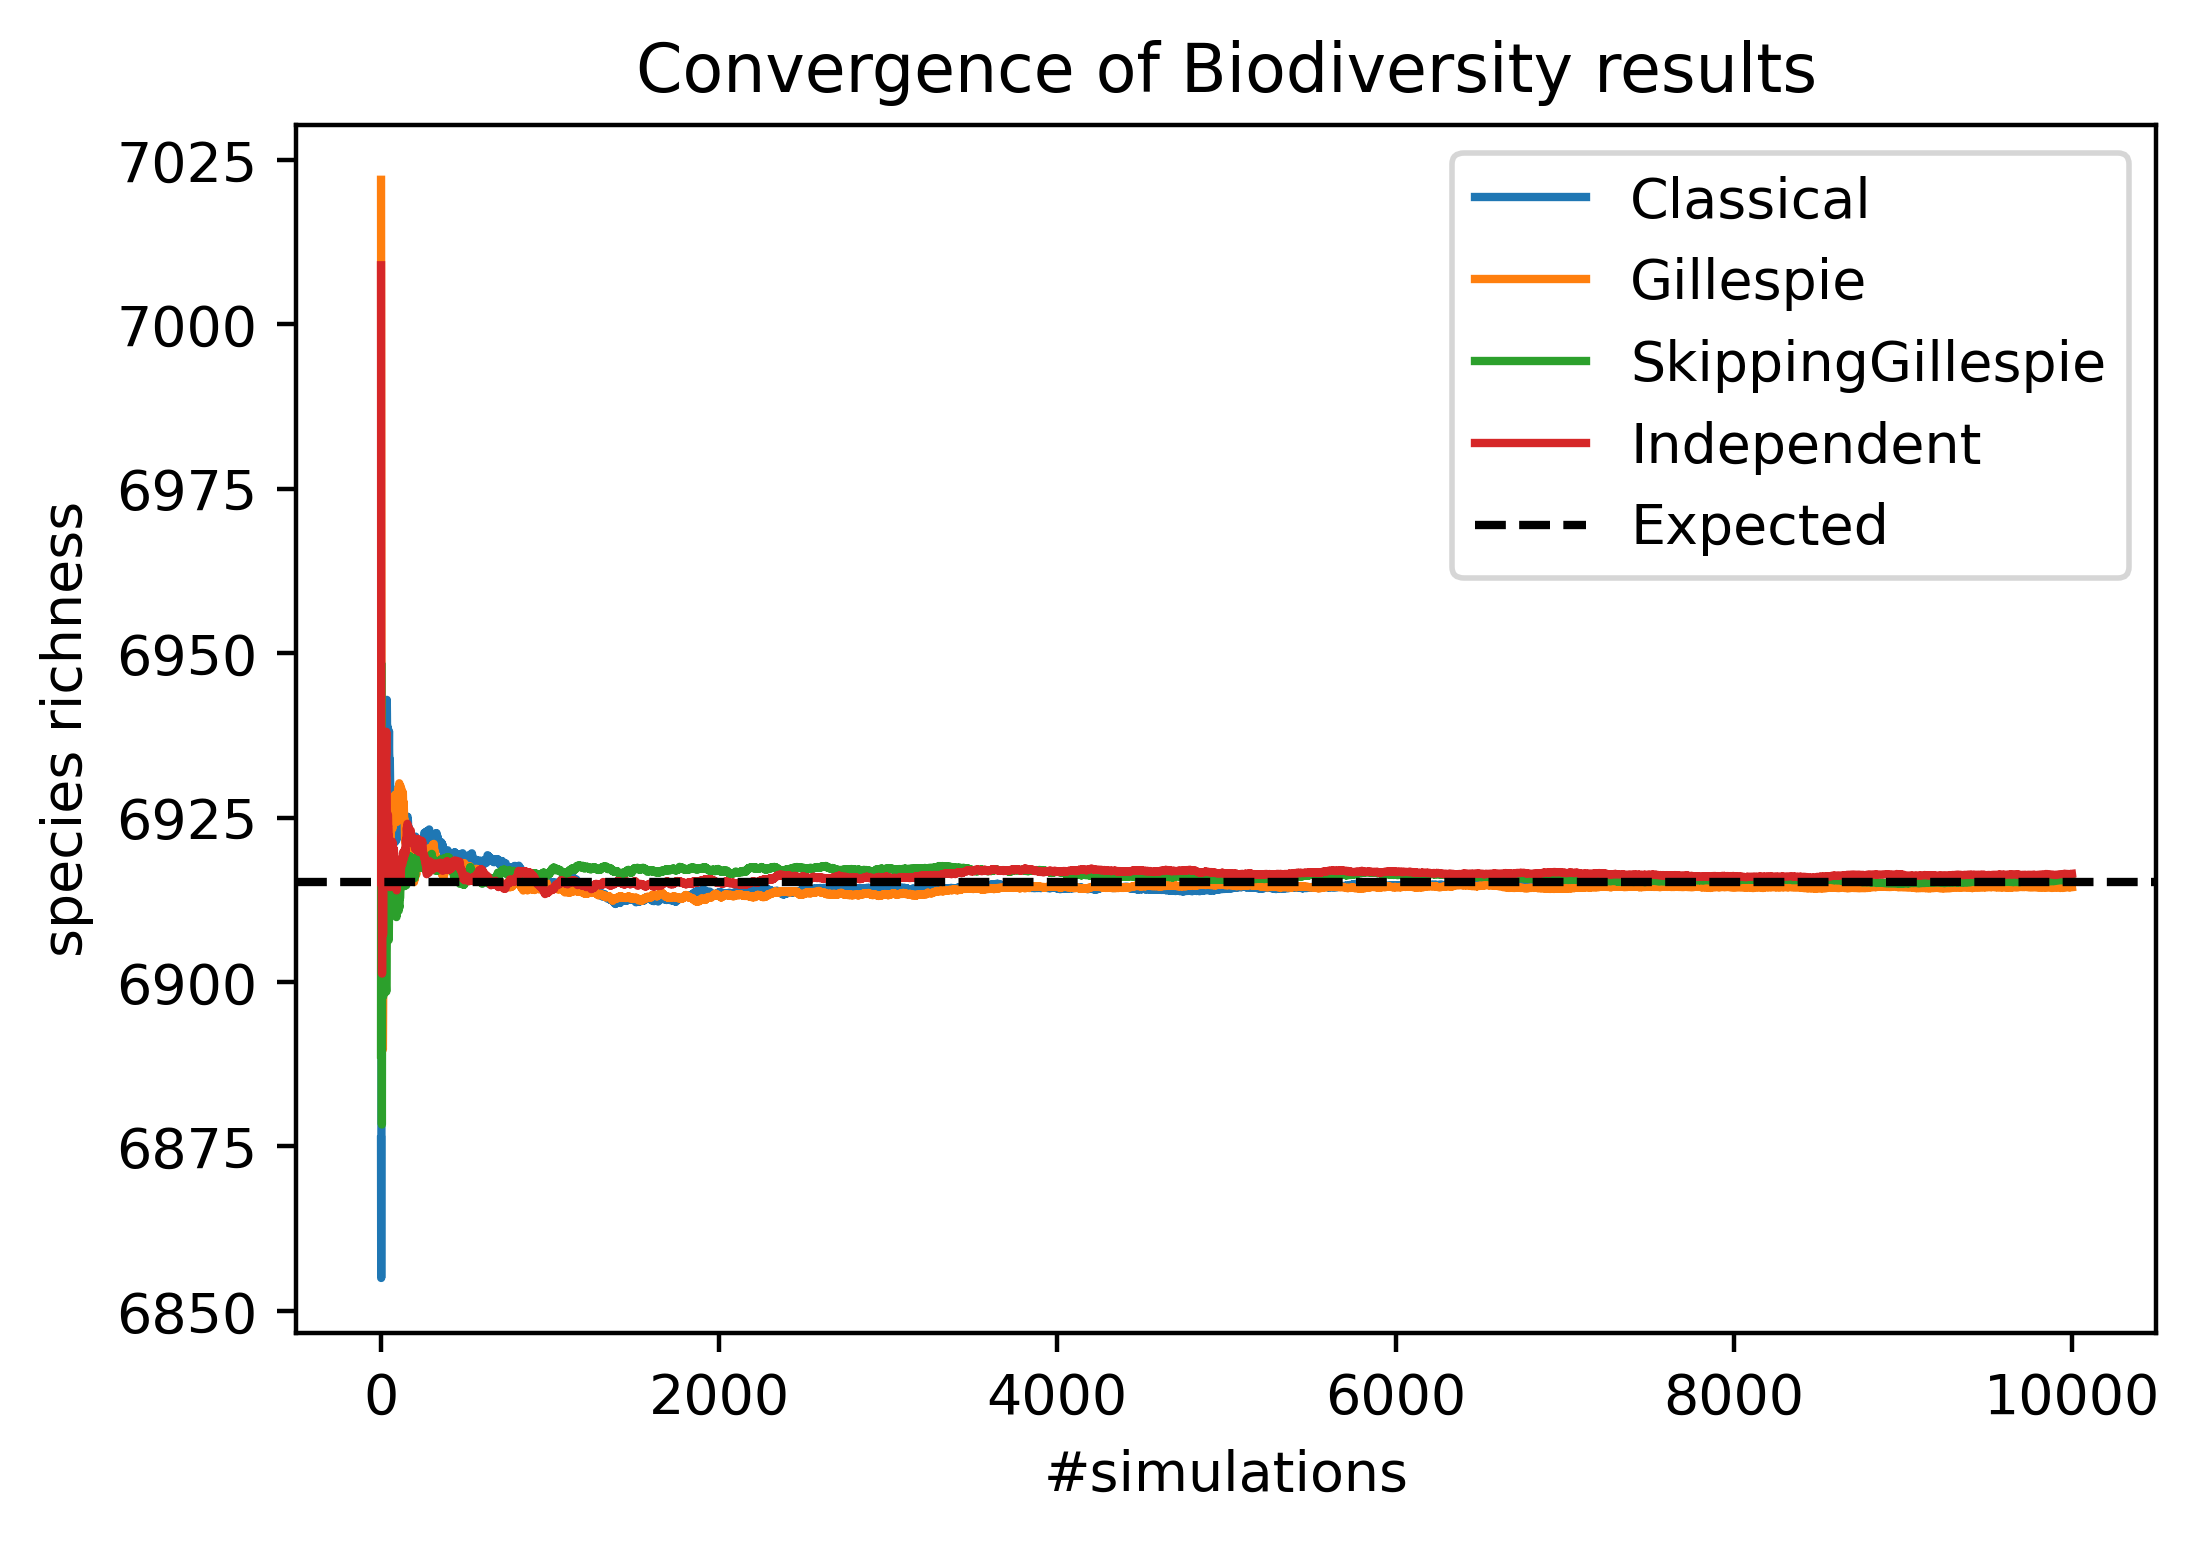

In [9]:
plt.title("Convergence of Biodiversity results")
plt.xlabel("#simulations")
plt.ylabel("species richness")

for algorithm, result in results.items():
    biodiversities, times, steps = tuple(zip(*result))
    
    plt.plot(
        range(1, len(biodiversities) + 1),
        np.cumsum(biodiversities)[0:] / np.arange(1, len(biodiversities) + 1),
        label=algorithm[:algorithm.find('(')]
    )

plt.axhline(y=s_island(100*100, 100, 0.001), color='black', linestyle='--', label="Expected")

plt.legend()
plt.show()

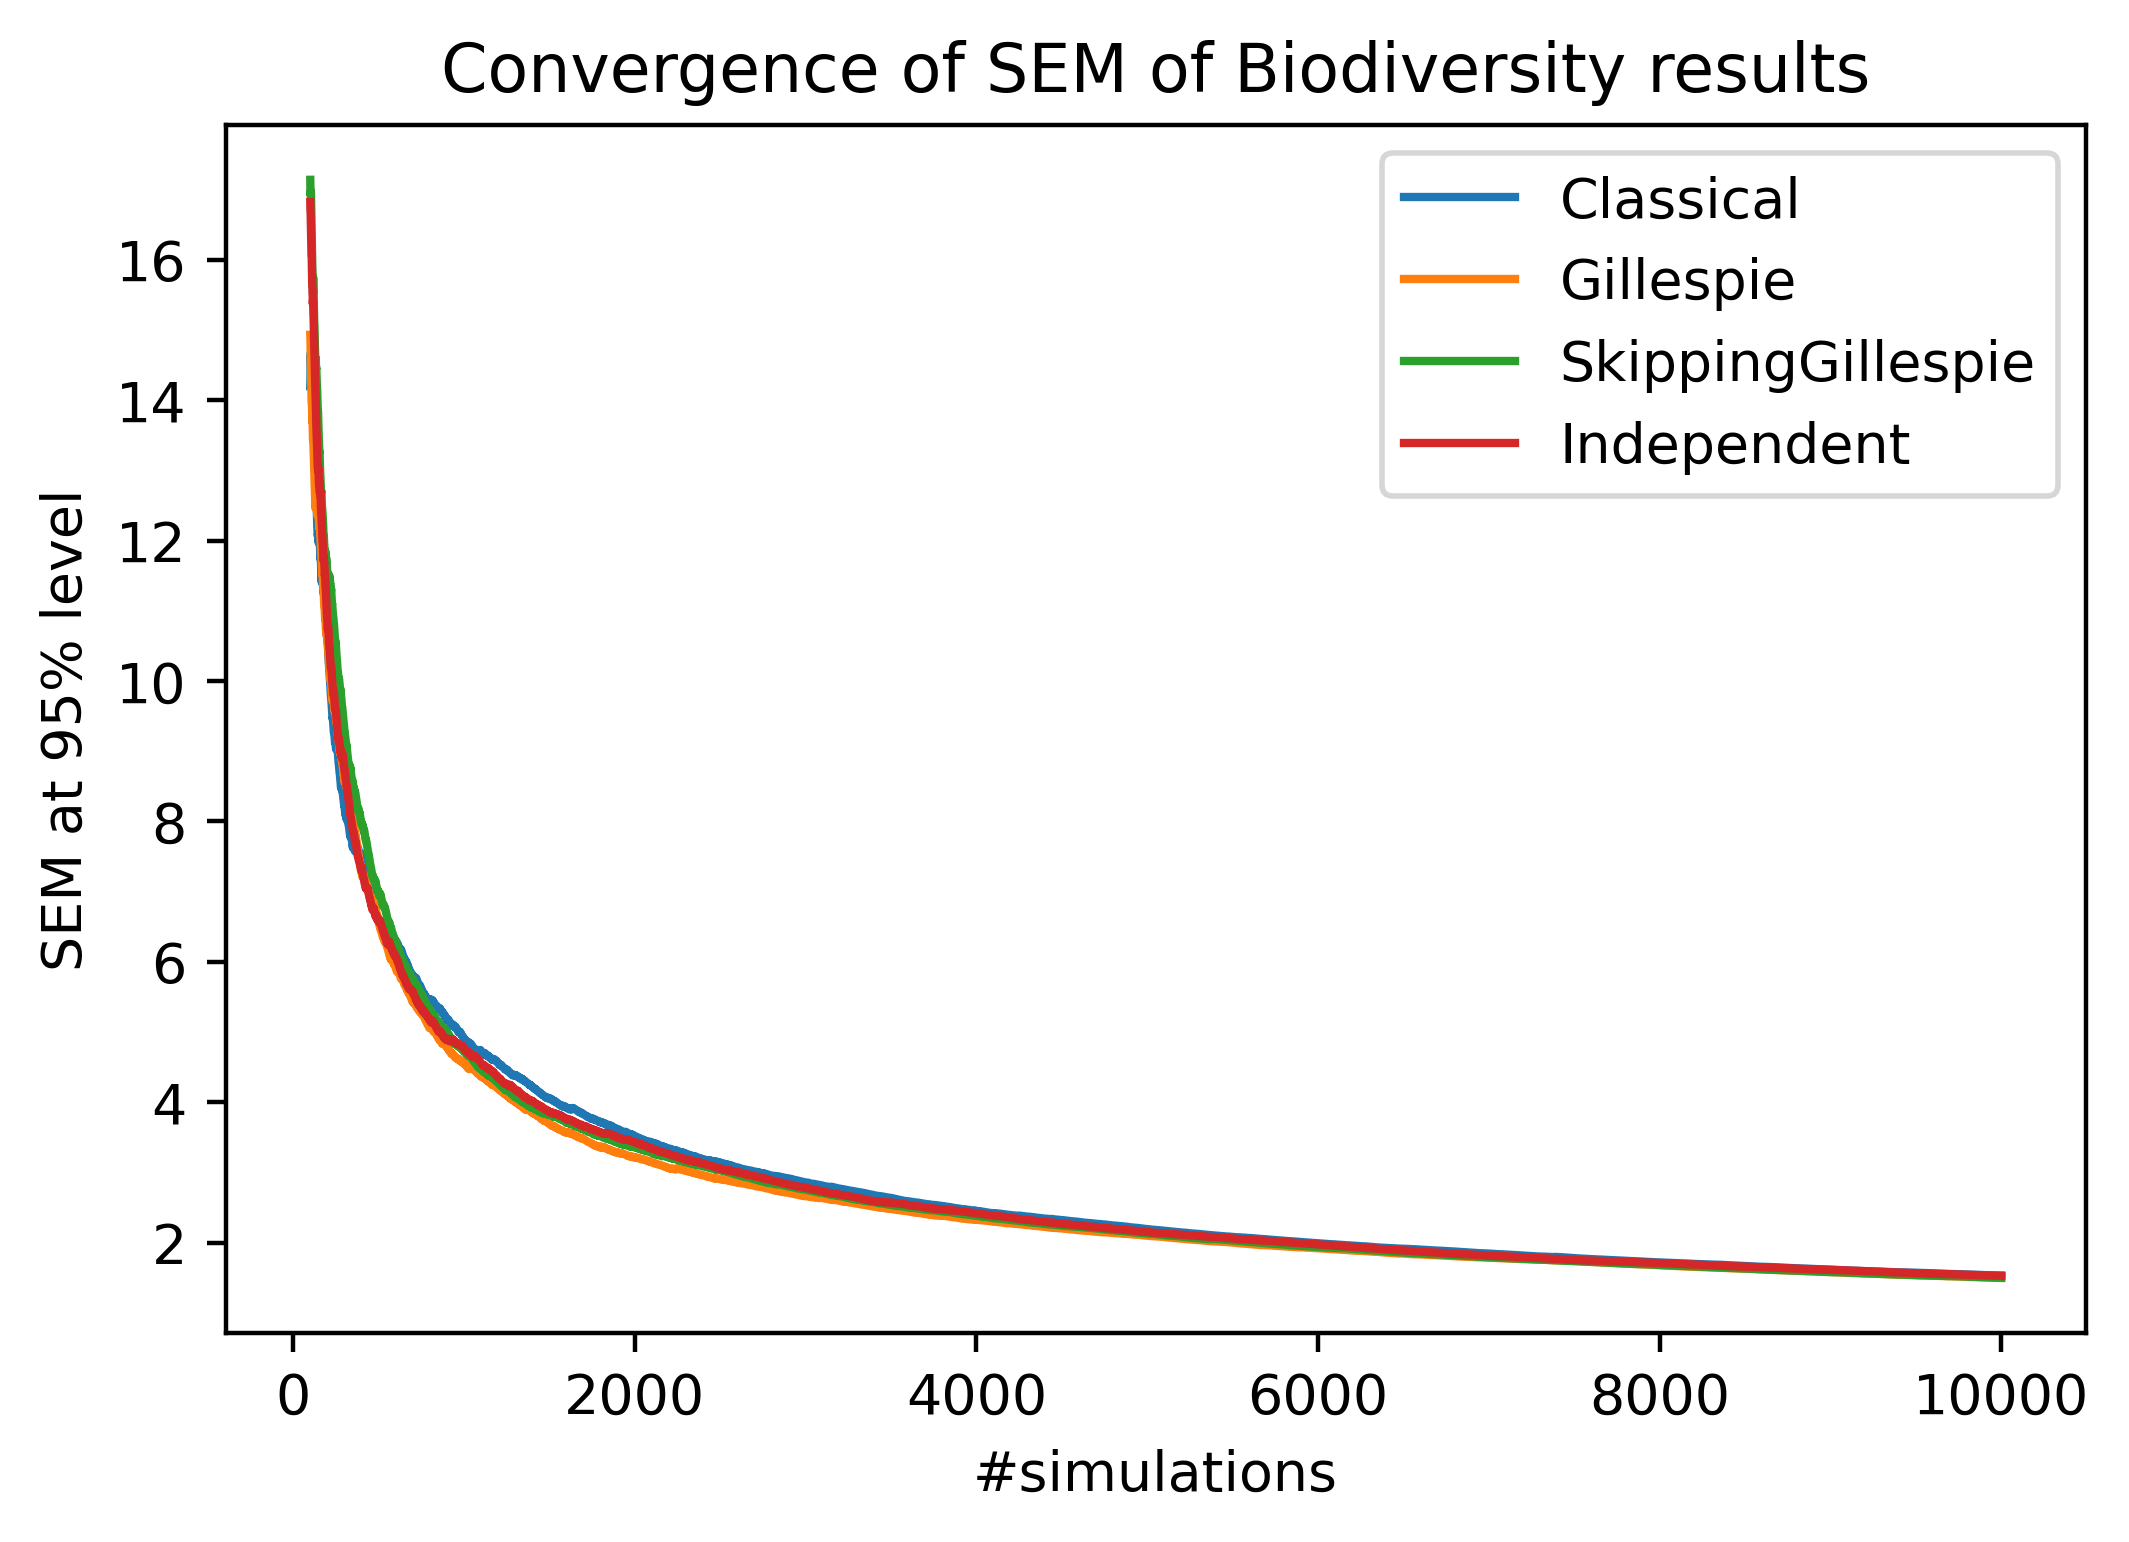

In [10]:
plt.title("Convergence of SEM of Biodiversity results")
plt.xlabel("#simulations")
plt.ylabel("SEM at 95% level")

for algorithm, result in results.items():
    biodiversities, times, steps = tuple(zip(*result))
    
    plt.plot(
        range(100, len(biodiversities) + 1),
        [stats.sem(biodiversities[:i]) * stats.t.ppf((1.95) * 0.5, i - 1) for i in range(100, len(biodiversities) + 1)],
        label=algorithm[:algorithm.find('(')]
    )

plt.legend()
plt.show()